In [33]:
%matplotlib inline
import pandas as pd
import caselawnet
import os
import json
from matplotlib import pyplot as plt

Load a network (created with caselawnet):

In [48]:
fn = '/media/sf_VBox_Shared/CaseLaw/graphs/json_sigma/wgaans_community.json'
with open(fn) as f:
    network = json.load(f)

In [49]:
nodes_df = pd.DataFrame(network['nodes'])
links_df = pd.DataFrame(network['edges'])

In [122]:
network['edges']

[{'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2012:BV1295_http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2011:BR5215',
  'source': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2012:BV1295',
  'target': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2011:BR5215'},
 {'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782_http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2004:AR3290',
  'source': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782',
  'target': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2004:AR3290'},
 {'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782_http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2000:AA5635',
  'source': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782',
  'target': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2000:AA5635'},
 {'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2007:B

In [139]:
[l for l in network['edges'] 
                      if l['source'] in nodes_df['id'].as_matrix()
                     and l['target'] in nodes_df['id'].as_matrix()]

[{'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2012:BV1295_http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2011:BR5215',
  'source': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2012:BV1295',
  'target': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2011:BR5215'},
 {'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782_http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2004:AR3290',
  'source': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782',
  'target': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2004:AR3290'},
 {'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782_http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2000:AA5635',
  'source': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2005:AT8782',
  'target': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2000:AA5635'},
 {'id': 'http://deeplink.rechtspraak.nl/uitspraak?id=ECLI:NL:HR:2007:B

Create a new network for each year:

In [168]:
networks = {}

for year in nodes_df['year'].unique():
    nodes_filtered_df = nodes_df[nodes_df['year']<=year]
    nodes_filtered = nodes_filtered_df.to_dict(orient='records')
    links_filtered = [l for l in network['edges'] 
                      if l['source'] in nodes_filtered_df['id'].as_matrix()
                     and l['target'] in nodes_filtered_df['id'].as_matrix()]
    if len(links_filtered) > 0:
        nodes_year = caselawnet.network_analysis.add_network_statistics(nodes_filtered.copy(), links_filtered.copy())
        networks[year] = {'nodes': nodes_year, 'edges': links_year}

In [169]:
years = networks.keys()
nodes_total_df =  pd.concat(
    [pd.DataFrame(networks[year]['nodes']).set_index('ecli') for year in years], keys=years) 
nodes_total_df = nodes_total_df.sort_index()

In [170]:
nodes_total_df

abstract  \
     ecli                                                                        
1987 ECLI:NL:HR:1969:AC4973                                                      
     ECLI:NL:HR:1975:AC5607                                                      
     ECLI:NL:HR:1976:AC5837                                                      
     ECLI:NL:HR:1978:AC3514                                                      
     ECLI:NL:HR:1982:AC0442                                                      
     ECLI:NL:HR:1982:AG4420                                                      
     ECLI:NL:HR:1983:AG4611                                                      
     ECLI:NL:HR:1987:AC3826                                                      
     ECLI:NL:HR:1987:AG5504                                                      
1989 ECLI:NL:HR:1969:AC4973                                                      
     ECLI:NL:HR:1975:AC5607                                                      
     ECLI:NL:HR:1976:AC5837                                                      
     ECLI:NL:HR:1978:AC3514                                                      
     ECLI:NL:HR:1982:AC0442                                                      
     ECLI:NL:HR:1982:AG4420                                                      
     ECLI:NL:HR:1983:AG4611                                                      
     ECLI:NL:HR:1987:AC3826                                                      
     ECLI:NL:HR:1987:AG5504                                                      
     ECLI:NL:HR:1989:AB9375                                                      
     ECLI:NL:HR:1989:AD0808                                                      
1990 ECLI:NL:HR:1969:AC4973                                                      
     ECLI:NL:HR:1975:AC5607                                                      
     ECLI:NL:HR:1976:AC5837                                                      
     ECLI:NL:HR:1978:AC3514                                                      
     ECLI:NL:HR:1982:AC0442                                                      
     ECLI:NL:HR:1982:AG4420                                                      
     ECLI:NL:HR:1983:AG4611                                                      
     ECLI:NL:HR:1987:AC3826                                                      
     ECLI:NL:HR:1987:AG5504                                                      
     ECLI:NL:HR:1989:AB9375                                                      
...                                                                        ...   
2015 ECLI:NL:HR:2009:BJ7832  Sociale zekerheidsrecht. Regresrecht ex art. 8...   
     ECLI:NL:HR:2010:BK4476  Luchtvaartwet (LVW), schadeloosstelling ex art...   
     ECLI:NL:HR:2010:BM7041  Arbeidsrecht. Verjaring van op grond van art. ...   
     ECLI:NL:HR:2010:BM7808  Verbintenissenrecht/verzekeringsrecht. Verreke...   
     ECLI:NL:HR:2010:BN3831  Inkomstenbelasting/premie volksverzekeringen; ...   
     ECLI:NL:HR:2010:BN6236  Bezittersaansprakelijkheid voor verschuiving k...   
     ECLI:NL:HR:2010:BN9977  Arbeidsrecht. Arbeidsongeval in de zin van art...   
     ECLI:NL:HR:2010:BO1799  Verbintenissenrecht. Beheerovereenkomst. Zorgp...   
     ECLI:NL:HR:2011:BP9991  Arbeidsrecht/Procesrecht. Vordering tot vergoe...   
     ECLI:NL:HR:2011:BQ3514  Arbeidsrecht. Schade werknemer als gevolg van ...   
     ECLI:NL:HR:2011:BQ3517  Arbeidsrecht. Schade werknemer als gevolg van ...   
     ECLI:NL:HR:2011:BQ3519  Arbeidsrecht. Schade werknemer als gevolg van ...   
     ECLI:NL:HR:2011:BR5215  Werkgeversaansprakelijkheid. Letsel werknemer ...   
     ECLI:NL:HR:2011:BR5223  Werkgeversaansprakelijkheid. Letsel werknemer ...   
     ECLI:NL:HR:2011:BU7412  Cassatie in belang der wet. Koop. Ook aan part...   
     ECLI:NL:HR:2012:BV1295  Uitleg dekkingsomvang AVB-polis. Aansprakelijk...   
     ECLI:NL:HR:2012:BX0598  (Appel)procesrecht. Rec

Plot the size of the network (nr of cases) as a function of the year:

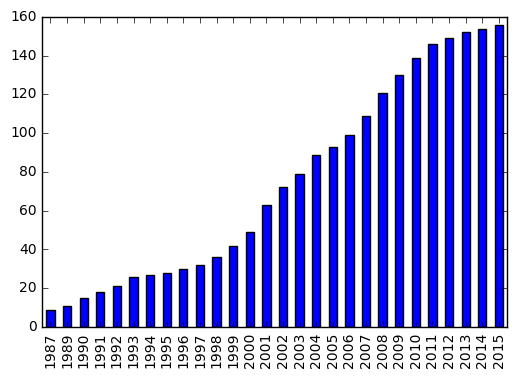

In [171]:
nodes_total_df.groupby(level=0)['id'].count().plot(kind='bar')

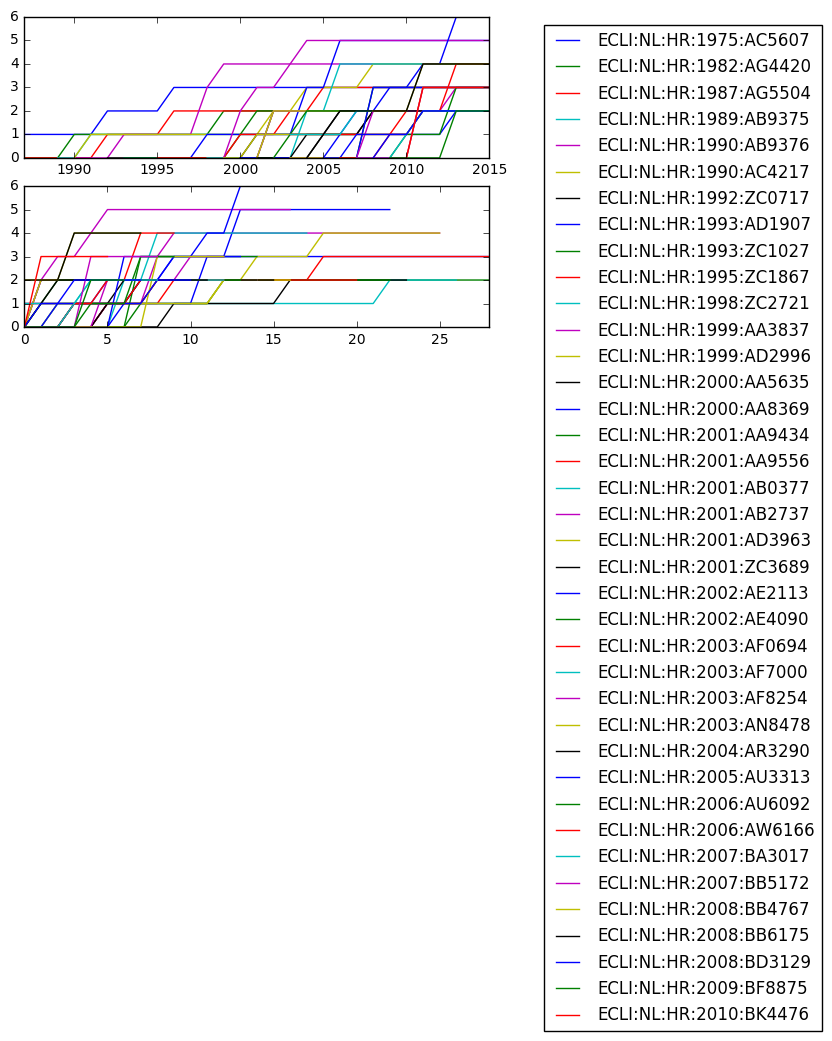

In [198]:
fig, axes = plt.subplots(2, sharex=False)
for ecli in nodes_total_df.index.levels[1]:
    ecli_data = nodes_total_df.xs(ecli, level=1)['in_degree']
    if(max(ecli_data)>1):
        ecli_data.plot(ax=axes[0], label=ecli)
        since_start = ecli_data.copy()
        since_start.index = since_start.index - min(since_start.index)
        since_start.plot(ax=axes[1], label=ecli)
axes[0].legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.show()